In [1]:
# 首先导入包
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import torchvision.models as models
# This is for the progress bar.
from tqdm import tqdm
import seaborn as sns
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import math
from torch.nn import functional as F

In [2]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_test_split(data_set, test_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(test_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [3]:
data = pd.read_csv("TripData_cleaned.csv")
data = data.drop('Unnamed: 0', axis=1)
data.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,Passenger_count,Trip_distance,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Total_amount,Trip_duration,Pickup_time,Speed,Pickup_cluster,Dropoff_cluster,year,month,day,time_span
0,2015-04-01 00:00:00,2015/4/1 0:08,1,3.08,-73.958817,40.716824,-73.982971,40.696007,14.76,8.0,1.427818e+09,23.100000,8,12,2015,4,1,0
1,2015-04-01 00:00:00,2015/4/1 0:07,1,1.21,-73.937531,40.804501,-73.946800,40.815998,8.30,7.0,1.427818e+09,10.371429,24,5,2015,4,1,0
2,2015-04-01 00:00:00,2015/4/1 0:02,1,0.64,-73.955818,40.681152,-73.955406,40.687145,6.00,2.0,1.427818e+09,19.200000,29,29,2015,4,1,0
3,2015-04-01 00:00:00,2015/4/1 0:05,1,1.34,-73.830551,40.759460,-73.825363,40.741589,7.80,5.0,1.427818e+09,16.080000,13,13,2015,4,1,0
4,2015-04-01 00:00:00,2015/4/1 0:05,1,0.98,-73.912086,40.775356,-73.915474,40.764091,7.30,5.0,1.427818e+09,11.760000,25,7,2015,4,1,0


In [4]:
# 根据指定的列进行分组，并对Passenger_count进行求和
grouped_data = data.groupby(['year', 'month', 'day', 'time_span', 'Pickup_cluster']).agg(
    {'Passenger_count': 'sum'}).reset_index()

grouped_data.head()

,year,month,day,time_span,Pickup_cluster,Passenger_count
0,2015,4,1,0,0,241
1,2015,4,1,0,1,80
2,2015,4,1,0,2,41
3,2015,4,1,0,3,72
4,2015,4,1,0,4,119


In [5]:
class TripData(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

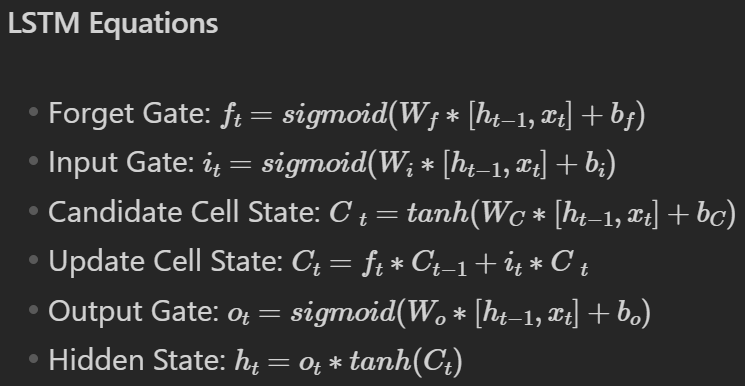
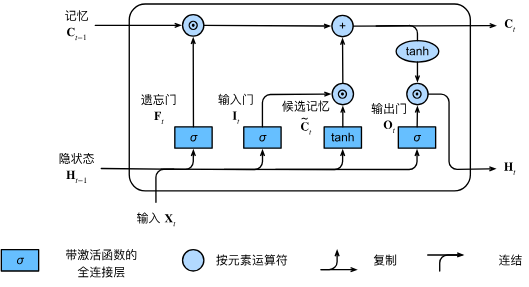

In [6]:
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device) # 初始化隐藏状态h0
        c0 = torch.zeros(self.num_layers,x.size(0), self.hidden_size).to(device)  # 初始化记忆状态c0
        #print(f"x.shape:{x.shape},h0.shape:{h0.shape},c0.shape:{c0.shape}")
        out, _ = self.lstm(x, (h0, c0))  # LSTM前向传播
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出作为预测结果
        return out

In [7]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-1], valid_data[:,:-1], test_data

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = [0,1,2,3,4] # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

In [8]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss() # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    optimizer=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.5,0.999))

    writer = SummaryWriter() # Writer of tensoboard.

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Test loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/Test', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 20010106,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'test_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 64, 
    'learning_rate': 1e-4,              
    'early_stop': 400,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/LSTM.ckpt'  # Your model will be saved here.
}

In [10]:
Passenger_count=grouped_data['Passenger_count'].values
print(f"len(Passenger_count):{len(Passenger_count)}")

len(Passenger_count):13441


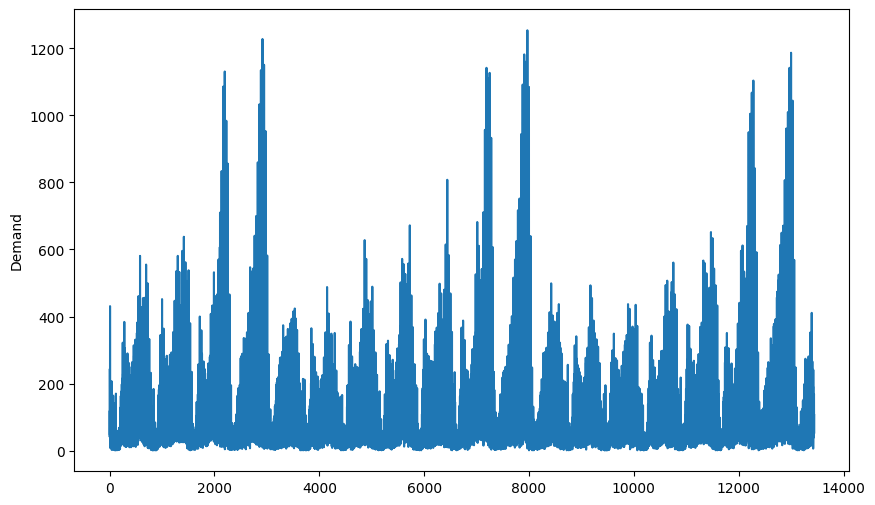

In [11]:
plt.figure(figsize = (10,6))
plt.plot([i for i in range(len(Passenger_count))],Passenger_count)
plt.ylabel("Demand", fontsize = 10)
plt.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler
# 创建MinMaxScaler对象
scaler = MinMaxScaler()
# 将数据进行归一化
Passenger_count = scaler.fit_transform(Passenger_count.reshape(-1,1))

In [13]:
def split_data(data,time_step=24):
    dataX=[]
    datay=[]
    dataNew = []
    for i in range(len(data)-time_step):
        dataX.append(data[i:i+time_step])
        datay.append(data[i+time_step])
        dataNew.append(data[i:i+time_step+1])
    dataX=np.array(dataX).reshape(len(dataX),time_step,-1)
    datay=np.array(datay)
    dataNew=np.array(dataNew).reshape(len(dataNew),time_step+1,-1)
    return dataX,datay,dataNew

In [14]:
dataX,datay, dataNew=split_data(Passenger_count)
print(f"dataX.shape:{dataX.shape},datay.shape:{datay.shape},dataNew.shape:{dataNew.shape}")

dataX.shape:(13417, 24, 1),datay.shape:(13417, 1),dataNew.shape:(13417, 25, 1)


In [15]:
# 计算验证集的大小（后10%的数据）
valid_size = int(len(dataNew) * 0.1)

# 从数据集的末尾取后10%作为验证集
valid_data = dataNew[-valid_size:]

In [16]:
train_data, test_data = train_test_split(dataNew, config['test_ratio'], config['seed'])

In [17]:
# Select features
x_train, x_test, y_train, y_test = train_data[:,:-1], test_data[:,:-1], train_data[:,-1], test_data[:,-1],

# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

number of features: 24


In [18]:
train_dataset, valid_dataset = TripData(x_train, y=y_train), TripData(x_test, y=y_test),

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

In [19]:
# 定义输入、隐藏状态和输出维度
input_size = 1  # 输入特征维度
hidden_size = 64  # LSTM隐藏状态维度
num_layers = 5  # LSTM层数
output_size = 1  # 输出维度（预测目标维度）

In [20]:
model = LSTM_model(input_size, hidden_size, num_layers, output_size).to(device) # put your model and data on the same computation device.
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 117.32it/s, loss=0.00671]


Epoch [1/500]: Train loss: 0.0100, Test loss: 0.0071
Saving model with loss 0.007...


Epoch [2/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.55it/s, loss=0.00332]


Epoch [2/500]: Train loss: 0.0075, Test loss: 0.0070
Saving model with loss 0.007...


Epoch [3/500]: 100%|███████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.49it/s, loss=0.0153]


Epoch [3/500]: Train loss: 0.0069, Test loss: 0.0059
Saving model with loss 0.006...


Epoch [4/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.99it/s, loss=0.00316]


Epoch [4/500]: Train loss: 0.0063, Test loss: 0.0060


Epoch [5/500]: 100%|███████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.54it/s, loss=0.0199]


Epoch [5/500]: Train loss: 0.0062, Test loss: 0.0067


Epoch [6/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.87it/s, loss=0.00455]


Epoch [6/500]: Train loss: 0.0062, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [7/500]: 100%|███████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.50it/s, loss=0.0107]


Epoch [7/500]: Train loss: 0.0062, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [8/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.30it/s, loss=0.00376]


Epoch [8/500]: Train loss: 0.0062, Test loss: 0.0058


Epoch [9/500]: 100%|███████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.88it/s, loss=0.0037]


Epoch [9/500]: Train loss: 0.0062, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [10/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.34it/s, loss=0.00286]


Epoch [10/500]: Train loss: 0.0062, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [11/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.96it/s, loss=0.00327]


Epoch [11/500]: Train loss: 0.0061, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [12/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.46it/s, loss=0.00417]


Epoch [12/500]: Train loss: 0.0061, Test loss: 0.0057


Epoch [13/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 125.42it/s, loss=0.00504]


Epoch [13/500]: Train loss: 0.0061, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [14/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.79it/s, loss=0.00413]


Epoch [14/500]: Train loss: 0.0061, Test loss: 0.0057


Epoch [15/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.40it/s, loss=0.00346]


Epoch [15/500]: Train loss: 0.0061, Test loss: 0.0057


Epoch [16/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.46it/s, loss=0.00637]


Epoch [16/500]: Train loss: 0.0061, Test loss: 0.0057


Epoch [17/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.99it/s, loss=0.00424]


Epoch [17/500]: Train loss: 0.0061, Test loss: 0.0057


Epoch [18/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.07it/s, loss=0.0266]


Epoch [18/500]: Train loss: 0.0061, Test loss: 0.0057
Saving model with loss 0.006...


Epoch [19/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.38it/s, loss=0.00391]


Epoch [19/500]: Train loss: 0.0061, Test loss: 0.0061


Epoch [20/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.95it/s, loss=0.0096]


Epoch [20/500]: Train loss: 0.0061, Test loss: 0.0056
Saving model with loss 0.006...


Epoch [21/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.01it/s, loss=0.00358]


Epoch [21/500]: Train loss: 0.0061, Test loss: 0.0056
Saving model with loss 0.006...


Epoch [22/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.45it/s, loss=0.00389]


Epoch [22/500]: Train loss: 0.0061, Test loss: 0.0056
Saving model with loss 0.006...


Epoch [23/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.79it/s, loss=0.00492]


Epoch [23/500]: Train loss: 0.0061, Test loss: 0.0058


Epoch [24/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 124.28it/s, loss=0.00352]


Epoch [24/500]: Train loss: 0.0060, Test loss: 0.0056
Saving model with loss 0.006...


Epoch [25/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 150.50it/s, loss=0.00354]


Epoch [25/500]: Train loss: 0.0060, Test loss: 0.0056


Epoch [26/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.55it/s, loss=0.00437]


Epoch [26/500]: Train loss: 0.0060, Test loss: 0.0056


Epoch [27/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.30it/s, loss=0.00448]


Epoch [27/500]: Train loss: 0.0060, Test loss: 0.0056


Epoch [28/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 124.58it/s, loss=0.00429]


Epoch [28/500]: Train loss: 0.0060, Test loss: 0.0055
Saving model with loss 0.006...


Epoch [29/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.94it/s, loss=0.00686]


Epoch [29/500]: Train loss: 0.0060, Test loss: 0.0057


Epoch [30/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.49it/s, loss=0.00452]


Epoch [30/500]: Train loss: 0.0060, Test loss: 0.0055
Saving model with loss 0.006...


Epoch [31/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 146.10it/s, loss=0.00455]


Epoch [31/500]: Train loss: 0.0059, Test loss: 0.0056


Epoch [32/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.97it/s, loss=0.00386]


Epoch [32/500]: Train loss: 0.0059, Test loss: 0.0055
Saving model with loss 0.005...


Epoch [33/500]: 100%|███████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.35it/s, loss=0.005]


Epoch [33/500]: Train loss: 0.0059, Test loss: 0.0057


Epoch [34/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.76it/s, loss=0.0033]


Epoch [34/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [35/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.30it/s, loss=0.00317]


Epoch [35/500]: Train loss: 0.0059, Test loss: 0.0055
Saving model with loss 0.005...


Epoch [36/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.80it/s, loss=0.00877]


Epoch [36/500]: Train loss: 0.0059, Test loss: 0.0058


Epoch [37/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.76it/s, loss=0.00525]


Epoch [37/500]: Train loss: 0.0059, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [38/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.56it/s, loss=0.00665]


Epoch [38/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [39/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 125.85it/s, loss=0.00381]


Epoch [39/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [40/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 118.67it/s, loss=0.00496]


Epoch [40/500]: Train loss: 0.0059, Test loss: 0.0056


Epoch [41/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.28it/s, loss=0.00353]


Epoch [41/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [42/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.70it/s, loss=0.00492]


Epoch [42/500]: Train loss: 0.0059, Test loss: 0.0056


Epoch [43/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.32it/s, loss=0.00521]


Epoch [43/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [44/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 120.23it/s, loss=0.00657]


Epoch [44/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [45/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.89it/s, loss=0.0036]


Epoch [45/500]: Train loss: 0.0059, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [46/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.74it/s, loss=0.00348]


Epoch [46/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [47/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.38it/s, loss=0.00637]


Epoch [47/500]: Train loss: 0.0059, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [48/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 121.16it/s, loss=0.00399]


Epoch [48/500]: Train loss: 0.0059, Test loss: 0.0055


Epoch [49/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 122.48it/s, loss=0.00851]


Epoch [49/500]: Train loss: 0.0059, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [50/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.30it/s, loss=0.00257]


Epoch [50/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [51/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.55it/s, loss=0.00677]


Epoch [51/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [52/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.31it/s, loss=0.00473]


Epoch [52/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [53/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 124.66it/s, loss=0.00379]


Epoch [53/500]: Train loss: 0.0058, Test loss: 0.0055


Epoch [54/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.04it/s, loss=0.00244]


Epoch [54/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [55/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.32it/s, loss=0.00226]


Epoch [55/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [56/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.47it/s, loss=0.00552]


Epoch [56/500]: Train loss: 0.0058, Test loss: 0.0055


Epoch [57/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.88it/s, loss=0.00309]


Epoch [57/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [58/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.07it/s, loss=0.00438]


Epoch [58/500]: Train loss: 0.0058, Test loss: 0.0054


Epoch [59/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.17it/s, loss=0.0061]


Epoch [59/500]: Train loss: 0.0058, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [60/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 161.13it/s, loss=0.00288]


Epoch [60/500]: Train loss: 0.0058, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [61/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.24it/s, loss=0.00276]


Epoch [61/500]: Train loss: 0.0058, Test loss: 0.0054
Saving model with loss 0.005...


Epoch [62/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.31it/s, loss=0.00349]


Epoch [62/500]: Train loss: 0.0057, Test loss: 0.0053
Saving model with loss 0.005...


Epoch [63/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.08it/s, loss=0.00514]


Epoch [63/500]: Train loss: 0.0058, Test loss: 0.0053
Saving model with loss 0.005...


Epoch [64/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.09it/s, loss=0.00593]


Epoch [64/500]: Train loss: 0.0057, Test loss: 0.0054


Epoch [65/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 120.39it/s, loss=0.00365]


Epoch [65/500]: Train loss: 0.0057, Test loss: 0.0052
Saving model with loss 0.005...


Epoch [66/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.94it/s, loss=0.00249]


Epoch [66/500]: Train loss: 0.0057, Test loss: 0.0052
Saving model with loss 0.005...


Epoch [67/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.42it/s, loss=0.00658]


Epoch [67/500]: Train loss: 0.0057, Test loss: 0.0053


Epoch [68/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 129.65it/s, loss=0.00234]


Epoch [68/500]: Train loss: 0.0057, Test loss: 0.0053


Epoch [69/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.00it/s, loss=0.0152]


Epoch [69/500]: Train loss: 0.0057, Test loss: 0.0052


Epoch [70/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.67it/s, loss=0.00386]


Epoch [70/500]: Train loss: 0.0056, Test loss: 0.0052


Epoch [71/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 123.97it/s, loss=0.0056]


Epoch [71/500]: Train loss: 0.0056, Test loss: 0.0052


Epoch [72/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.48it/s, loss=0.00479]


Epoch [72/500]: Train loss: 0.0056, Test loss: 0.0050
Saving model with loss 0.005...


Epoch [73/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.39it/s, loss=0.00659]


Epoch [73/500]: Train loss: 0.0055, Test loss: 0.0050
Saving model with loss 0.005...


Epoch [74/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.61it/s, loss=0.00287]


Epoch [74/500]: Train loss: 0.0055, Test loss: 0.0050


Epoch [75/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.60it/s, loss=0.00359]


Epoch [75/500]: Train loss: 0.0054, Test loss: 0.0051


Epoch [76/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 130.30it/s, loss=0.00416]


Epoch [76/500]: Train loss: 0.0054, Test loss: 0.0053


Epoch [77/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.13it/s, loss=0.00346]


Epoch [77/500]: Train loss: 0.0053, Test loss: 0.0048
Saving model with loss 0.005...


Epoch [78/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 128.23it/s, loss=0.00613]


Epoch [78/500]: Train loss: 0.0053, Test loss: 0.0049


Epoch [79/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 138.36it/s, loss=0.00294]


Epoch [79/500]: Train loss: 0.0052, Test loss: 0.0048
Saving model with loss 0.005...


Epoch [80/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 155.27it/s, loss=0.00329]


Epoch [80/500]: Train loss: 0.0052, Test loss: 0.0048


Epoch [81/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.27it/s, loss=0.00664]


Epoch [81/500]: Train loss: 0.0051, Test loss: 0.0048


Epoch [82/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 163.42it/s, loss=0.00776]


Epoch [82/500]: Train loss: 0.0051, Test loss: 0.0050


Epoch [83/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.50it/s, loss=0.00399]


Epoch [83/500]: Train loss: 0.0052, Test loss: 0.0046
Saving model with loss 0.005...


Epoch [84/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.19it/s, loss=0.00287]


Epoch [84/500]: Train loss: 0.0050, Test loss: 0.0047


Epoch [85/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.00it/s, loss=0.00394]


Epoch [85/500]: Train loss: 0.0051, Test loss: 0.0046
Saving model with loss 0.005...


Epoch [86/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.68it/s, loss=0.00204]


Epoch [86/500]: Train loss: 0.0051, Test loss: 0.0045
Saving model with loss 0.005...


Epoch [87/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.06it/s, loss=0.00422]


Epoch [87/500]: Train loss: 0.0050, Test loss: 0.0046


Epoch [88/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 126.50it/s, loss=0.00421]


Epoch [88/500]: Train loss: 0.0050, Test loss: 0.0049


Epoch [89/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 146.17it/s, loss=0.00817]


Epoch [89/500]: Train loss: 0.0050, Test loss: 0.0046


Epoch [90/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.68it/s, loss=0.0046]


Epoch [90/500]: Train loss: 0.0050, Test loss: 0.0045


Epoch [91/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.82it/s, loss=0.00468]


Epoch [91/500]: Train loss: 0.0049, Test loss: 0.0044
Saving model with loss 0.004...


Epoch [92/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.62it/s, loss=0.00297]


Epoch [92/500]: Train loss: 0.0049, Test loss: 0.0048


Epoch [93/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.09it/s, loss=0.00462]


Epoch [93/500]: Train loss: 0.0049, Test loss: 0.0046


Epoch [94/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.77it/s, loss=0.00468]


Epoch [94/500]: Train loss: 0.0049, Test loss: 0.0044
Saving model with loss 0.004...


Epoch [95/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.53it/s, loss=0.00335]


Epoch [95/500]: Train loss: 0.0049, Test loss: 0.0045


Epoch [96/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.89it/s, loss=0.00437]


Epoch [96/500]: Train loss: 0.0048, Test loss: 0.0044
Saving model with loss 0.004...


Epoch [97/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.13it/s, loss=0.00634]


Epoch [97/500]: Train loss: 0.0048, Test loss: 0.0044
Saving model with loss 0.004...


Epoch [98/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.28it/s, loss=0.00595]


Epoch [98/500]: Train loss: 0.0048, Test loss: 0.0044


Epoch [99/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.48it/s, loss=0.00271]


Epoch [99/500]: Train loss: 0.0048, Test loss: 0.0045


Epoch [100/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 127.82it/s, loss=0.00633]


Epoch [100/500]: Train loss: 0.0048, Test loss: 0.0047


Epoch [101/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 159.78it/s, loss=0.00813]


Epoch [101/500]: Train loss: 0.0048, Test loss: 0.0045


Epoch [102/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 150.86it/s, loss=0.00285]


Epoch [102/500]: Train loss: 0.0048, Test loss: 0.0046


Epoch [103/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.98it/s, loss=0.00242]


Epoch [103/500]: Train loss: 0.0047, Test loss: 0.0044
Saving model with loss 0.004...


Epoch [104/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 153.22it/s, loss=0.00368]


Epoch [104/500]: Train loss: 0.0047, Test loss: 0.0044


Epoch [105/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 154.86it/s, loss=0.00246]


Epoch [105/500]: Train loss: 0.0047, Test loss: 0.0046


Epoch [106/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.73it/s, loss=0.00328]


Epoch [106/500]: Train loss: 0.0047, Test loss: 0.0044


Epoch [107/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.96it/s, loss=0.00783]


Epoch [107/500]: Train loss: 0.0047, Test loss: 0.0044


Epoch [108/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 162.17it/s, loss=0.00205]


Epoch [108/500]: Train loss: 0.0047, Test loss: 0.0044


Epoch [109/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 152.99it/s, loss=0.00659]


Epoch [109/500]: Train loss: 0.0047, Test loss: 0.0045


Epoch [110/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 152.20it/s, loss=0.00393]


Epoch [110/500]: Train loss: 0.0046, Test loss: 0.0047


Epoch [111/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.28it/s, loss=0.00453]


Epoch [111/500]: Train loss: 0.0046, Test loss: 0.0043
Saving model with loss 0.004...


Epoch [112/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 155.09it/s, loss=0.00433]


Epoch [112/500]: Train loss: 0.0046, Test loss: 0.0047


Epoch [113/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 153.59it/s, loss=0.00569]


Epoch [113/500]: Train loss: 0.0046, Test loss: 0.0051


Epoch [114/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.74it/s, loss=0.00511]


Epoch [114/500]: Train loss: 0.0047, Test loss: 0.0044


Epoch [115/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 161.58it/s, loss=0.00538]


Epoch [115/500]: Train loss: 0.0046, Test loss: 0.0042
Saving model with loss 0.004...


Epoch [116/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.23it/s, loss=0.00184]


Epoch [116/500]: Train loss: 0.0046, Test loss: 0.0045


Epoch [117/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.81it/s, loss=0.00366]


Epoch [117/500]: Train loss: 0.0046, Test loss: 0.0042
Saving model with loss 0.004...


Epoch [118/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.10it/s, loss=0.00398]


Epoch [118/500]: Train loss: 0.0045, Test loss: 0.0043


Epoch [119/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.36it/s, loss=0.00319]


Epoch [119/500]: Train loss: 0.0045, Test loss: 0.0042
Saving model with loss 0.004...


Epoch [120/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 165.26it/s, loss=0.00589]


Epoch [120/500]: Train loss: 0.0044, Test loss: 0.0042


Epoch [121/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 164.54it/s, loss=0.00412]


Epoch [121/500]: Train loss: 0.0045, Test loss: 0.0042


Epoch [122/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.14it/s, loss=0.00719]


Epoch [122/500]: Train loss: 0.0045, Test loss: 0.0041
Saving model with loss 0.004...


Epoch [123/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.85it/s, loss=0.00478]


Epoch [123/500]: Train loss: 0.0044, Test loss: 0.0044


Epoch [124/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.71it/s, loss=0.00451]


Epoch [124/500]: Train loss: 0.0045, Test loss: 0.0042


Epoch [125/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.99it/s, loss=0.00191]


Epoch [125/500]: Train loss: 0.0044, Test loss: 0.0042


Epoch [126/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.04it/s, loss=0.00354]


Epoch [126/500]: Train loss: 0.0044, Test loss: 0.0041
Saving model with loss 0.004...


Epoch [127/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.49it/s, loss=0.00463]


Epoch [127/500]: Train loss: 0.0043, Test loss: 0.0042


Epoch [128/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.96it/s, loss=0.0035]


Epoch [128/500]: Train loss: 0.0044, Test loss: 0.0042


Epoch [129/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.55it/s, loss=0.00215]


Epoch [129/500]: Train loss: 0.0043, Test loss: 0.0040
Saving model with loss 0.004...


Epoch [130/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.87it/s, loss=0.00371]


Epoch [130/500]: Train loss: 0.0043, Test loss: 0.0043


Epoch [131/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.94it/s, loss=0.00206]


Epoch [131/500]: Train loss: 0.0043, Test loss: 0.0042


Epoch [132/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 155.05it/s, loss=0.00616]


Epoch [132/500]: Train loss: 0.0043, Test loss: 0.0043


Epoch [133/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.36it/s, loss=0.00464]


Epoch [133/500]: Train loss: 0.0042, Test loss: 0.0041


Epoch [134/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 152.75it/s, loss=0.00323]


Epoch [134/500]: Train loss: 0.0042, Test loss: 0.0043


Epoch [135/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 150.24it/s, loss=0.00608]


Epoch [135/500]: Train loss: 0.0042, Test loss: 0.0041


Epoch [136/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 153.15it/s, loss=0.00504]


Epoch [136/500]: Train loss: 0.0041, Test loss: 0.0039
Saving model with loss 0.004...


Epoch [137/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.46it/s, loss=0.00332]


Epoch [137/500]: Train loss: 0.0042, Test loss: 0.0039
Saving model with loss 0.004...


Epoch [138/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.26it/s, loss=0.00978]


Epoch [138/500]: Train loss: 0.0041, Test loss: 0.0040


Epoch [139/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.71it/s, loss=0.00323]


Epoch [139/500]: Train loss: 0.0041, Test loss: 0.0039
Saving model with loss 0.004...


Epoch [140/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.61it/s, loss=0.00791]


Epoch [140/500]: Train loss: 0.0041, Test loss: 0.0049


Epoch [141/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.82it/s, loss=0.00272]


Epoch [141/500]: Train loss: 0.0041, Test loss: 0.0039


Epoch [142/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.18it/s, loss=0.00294]


Epoch [142/500]: Train loss: 0.0040, Test loss: 0.0039
Saving model with loss 0.004...


Epoch [143/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 130.57it/s, loss=0.00286]


Epoch [143/500]: Train loss: 0.0041, Test loss: 0.0039


Epoch [144/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.71it/s, loss=0.00327]


Epoch [144/500]: Train loss: 0.0040, Test loss: 0.0040


Epoch [145/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.51it/s, loss=0.00228]


Epoch [145/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [146/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.26it/s, loss=0.00306]


Epoch [146/500]: Train loss: 0.0040, Test loss: 0.0039


Epoch [147/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.62it/s, loss=0.00457]


Epoch [147/500]: Train loss: 0.0040, Test loss: 0.0041


Epoch [148/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.65it/s, loss=0.0031]


Epoch [148/500]: Train loss: 0.0039, Test loss: 0.0044


Epoch [149/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.69it/s, loss=0.00412]


Epoch [149/500]: Train loss: 0.0040, Test loss: 0.0039


Epoch [150/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.22it/s, loss=0.00378]


Epoch [150/500]: Train loss: 0.0039, Test loss: 0.0042


Epoch [151/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.79it/s, loss=0.00246]


Epoch [151/500]: Train loss: 0.0039, Test loss: 0.0039


Epoch [152/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.06it/s, loss=0.00296]


Epoch [152/500]: Train loss: 0.0039, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [153/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.71it/s, loss=0.00338]


Epoch [153/500]: Train loss: 0.0039, Test loss: 0.0040


Epoch [154/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 157.05it/s, loss=0.0049]


Epoch [154/500]: Train loss: 0.0038, Test loss: 0.0038
Saving model with loss 0.004...


Epoch [155/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.08it/s, loss=0.00333]


Epoch [155/500]: Train loss: 0.0038, Test loss: 0.0040


Epoch [156/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 153.51it/s, loss=0.00494]


Epoch [156/500]: Train loss: 0.0037, Test loss: 0.0038


Epoch [157/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.36it/s, loss=0.00552]


Epoch [157/500]: Train loss: 0.0037, Test loss: 0.0037
Saving model with loss 0.004...


Epoch [158/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.72it/s, loss=0.00314]


Epoch [158/500]: Train loss: 0.0037, Test loss: 0.0038


Epoch [159/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.46it/s, loss=0.00588]


Epoch [159/500]: Train loss: 0.0037, Test loss: 0.0037
Saving model with loss 0.004...


Epoch [160/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.77it/s, loss=0.00324]


Epoch [160/500]: Train loss: 0.0037, Test loss: 0.0036
Saving model with loss 0.004...


Epoch [161/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 154.17it/s, loss=0.00227]


Epoch [161/500]: Train loss: 0.0036, Test loss: 0.0038


Epoch [162/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.73it/s, loss=0.00357]


Epoch [162/500]: Train loss: 0.0036, Test loss: 0.0037


Epoch [163/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.11it/s, loss=0.0025]


Epoch [163/500]: Train loss: 0.0036, Test loss: 0.0041


Epoch [164/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.34it/s, loss=0.00508]


Epoch [164/500]: Train loss: 0.0035, Test loss: 0.0040


Epoch [165/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.33it/s, loss=0.00505]


Epoch [165/500]: Train loss: 0.0035, Test loss: 0.0038


Epoch [166/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 150.51it/s, loss=0.00538]


Epoch [166/500]: Train loss: 0.0035, Test loss: 0.0035
Saving model with loss 0.004...


Epoch [167/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 146.37it/s, loss=0.00479]


Epoch [167/500]: Train loss: 0.0035, Test loss: 0.0036


Epoch [168/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.04it/s, loss=0.00172]


Epoch [168/500]: Train loss: 0.0034, Test loss: 0.0036


Epoch [169/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 154.28it/s, loss=0.00532]


Epoch [169/500]: Train loss: 0.0034, Test loss: 0.0034
Saving model with loss 0.003...


Epoch [170/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.48it/s, loss=0.00405]


Epoch [170/500]: Train loss: 0.0034, Test loss: 0.0034
Saving model with loss 0.003...


Epoch [171/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.61it/s, loss=0.00268]


Epoch [171/500]: Train loss: 0.0033, Test loss: 0.0034


Epoch [172/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.61it/s, loss=0.00441]


Epoch [172/500]: Train loss: 0.0033, Test loss: 0.0039


Epoch [173/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.11it/s, loss=0.00387]


Epoch [173/500]: Train loss: 0.0033, Test loss: 0.0033
Saving model with loss 0.003...


Epoch [174/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.67it/s, loss=0.00221]


Epoch [174/500]: Train loss: 0.0032, Test loss: 0.0033


Epoch [175/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.98it/s, loss=0.00344]


Epoch [175/500]: Train loss: 0.0032, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [176/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 152.30it/s, loss=0.00248]


Epoch [176/500]: Train loss: 0.0032, Test loss: 0.0032
Saving model with loss 0.003...


Epoch [177/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.48it/s, loss=0.00196]


Epoch [177/500]: Train loss: 0.0032, Test loss: 0.0036


Epoch [178/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.88it/s, loss=0.00281]


Epoch [178/500]: Train loss: 0.0031, Test loss: 0.0030
Saving model with loss 0.003...


Epoch [179/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 153.75it/s, loss=0.00601]


Epoch [179/500]: Train loss: 0.0031, Test loss: 0.0032


Epoch [180/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 159.04it/s, loss=0.00159]


Epoch [180/500]: Train loss: 0.0030, Test loss: 0.0031


Epoch [181/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.37it/s, loss=0.00244]


Epoch [181/500]: Train loss: 0.0030, Test loss: 0.0034


Epoch [182/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.32it/s, loss=0.00189]


Epoch [182/500]: Train loss: 0.0030, Test loss: 0.0030
Saving model with loss 0.003...


Epoch [183/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.94it/s, loss=0.00331]


Epoch [183/500]: Train loss: 0.0029, Test loss: 0.0030


Epoch [184/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.80it/s, loss=0.0031]


Epoch [184/500]: Train loss: 0.0028, Test loss: 0.0030


Epoch [185/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.15it/s, loss=0.00272]


Epoch [185/500]: Train loss: 0.0028, Test loss: 0.0029
Saving model with loss 0.003...


Epoch [186/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.98it/s, loss=0.00284]


Epoch [186/500]: Train loss: 0.0028, Test loss: 0.0039


Epoch [187/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.06it/s, loss=0.00295]


Epoch [187/500]: Train loss: 0.0030, Test loss: 0.0033


Epoch [188/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.93it/s, loss=0.00177]


Epoch [188/500]: Train loss: 0.0027, Test loss: 0.0029
Saving model with loss 0.003...


Epoch [189/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.49it/s, loss=0.00224]


Epoch [189/500]: Train loss: 0.0028, Test loss: 0.0036


Epoch [190/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 127.04it/s, loss=0.00127]


Epoch [190/500]: Train loss: 0.0027, Test loss: 0.0029
Saving model with loss 0.003...


Epoch [191/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.17it/s, loss=0.00239]


Epoch [191/500]: Train loss: 0.0027, Test loss: 0.0030


Epoch [192/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.27it/s, loss=0.00221]


Epoch [192/500]: Train loss: 0.0026, Test loss: 0.0031


Epoch [193/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.38it/s, loss=0.00172]


Epoch [193/500]: Train loss: 0.0026, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [194/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.37it/s, loss=0.00244]


Epoch [194/500]: Train loss: 0.0025, Test loss: 0.0033


Epoch [195/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.87it/s, loss=0.00138]


Epoch [195/500]: Train loss: 0.0025, Test loss: 0.0028
Saving model with loss 0.003...


Epoch [196/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 125.80it/s, loss=0.0069]


Epoch [196/500]: Train loss: 0.0025, Test loss: 0.0030


Epoch [197/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.40it/s, loss=0.00194]


Epoch [197/500]: Train loss: 0.0026, Test loss: 0.0027
Saving model with loss 0.003...


Epoch [198/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.28it/s, loss=0.002]


Epoch [198/500]: Train loss: 0.0025, Test loss: 0.0029


Epoch [199/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 146.04it/s, loss=0.00198]


Epoch [199/500]: Train loss: 0.0024, Test loss: 0.0027


Epoch [200/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.13it/s, loss=0.00285]


Epoch [200/500]: Train loss: 0.0024, Test loss: 0.0030


Epoch [201/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.92it/s, loss=0.00214]


Epoch [201/500]: Train loss: 0.0024, Test loss: 0.0027
Saving model with loss 0.003...


Epoch [202/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.23it/s, loss=0.00276]


Epoch [202/500]: Train loss: 0.0023, Test loss: 0.0026
Saving model with loss 0.003...


Epoch [203/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.53it/s, loss=0.00165]


Epoch [203/500]: Train loss: 0.0024, Test loss: 0.0026


Epoch [204/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 124.08it/s, loss=0.00338]


Epoch [204/500]: Train loss: 0.0023, Test loss: 0.0032


Epoch [205/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.53it/s, loss=0.00169]


Epoch [205/500]: Train loss: 0.0023, Test loss: 0.0029


Epoch [206/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.99it/s, loss=0.00578]


Epoch [206/500]: Train loss: 0.0023, Test loss: 0.0025
Saving model with loss 0.003...


Epoch [207/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.57it/s, loss=0.00191]


Epoch [207/500]: Train loss: 0.0022, Test loss: 0.0024
Saving model with loss 0.002...


Epoch [208/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.48it/s, loss=0.00128]


Epoch [208/500]: Train loss: 0.0023, Test loss: 0.0025


Epoch [209/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.76it/s, loss=0.00254]


Epoch [209/500]: Train loss: 0.0022, Test loss: 0.0026


Epoch [210/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.81it/s, loss=0.00243]


Epoch [210/500]: Train loss: 0.0021, Test loss: 0.0025


Epoch [211/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 128.45it/s, loss=0.00304]


Epoch [211/500]: Train loss: 0.0022, Test loss: 0.0024


Epoch [212/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.64it/s, loss=0.00278]


Epoch [212/500]: Train loss: 0.0022, Test loss: 0.0032


Epoch [213/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.23it/s, loss=0.00268]


Epoch [213/500]: Train loss: 0.0022, Test loss: 0.0025


Epoch [214/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.09it/s, loss=0.00135]


Epoch [214/500]: Train loss: 0.0021, Test loss: 0.0026


Epoch [215/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.27it/s, loss=0.00132]


Epoch [215/500]: Train loss: 0.0021, Test loss: 0.0023
Saving model with loss 0.002...


Epoch [216/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.74it/s, loss=0.00186]


Epoch [216/500]: Train loss: 0.0020, Test loss: 0.0025


Epoch [217/500]: 100%|██████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.56it/s, loss=0.002]


Epoch [217/500]: Train loss: 0.0021, Test loss: 0.0025


Epoch [218/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 126.28it/s, loss=0.00255]


Epoch [218/500]: Train loss: 0.0020, Test loss: 0.0024


Epoch [219/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.26it/s, loss=0.00255]


Epoch [219/500]: Train loss: 0.0020, Test loss: 0.0022
Saving model with loss 0.002...


Epoch [220/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 138.51it/s, loss=0.00334]


Epoch [220/500]: Train loss: 0.0020, Test loss: 0.0025


Epoch [221/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 125.30it/s, loss=0.00338]


Epoch [221/500]: Train loss: 0.0020, Test loss: 0.0024


Epoch [222/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.48it/s, loss=0.00157]


Epoch [222/500]: Train loss: 0.0019, Test loss: 0.0023


Epoch [223/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.06it/s, loss=0.00289]


Epoch [223/500]: Train loss: 0.0020, Test loss: 0.0021
Saving model with loss 0.002...


Epoch [224/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 126.82it/s, loss=0.00279]


Epoch [224/500]: Train loss: 0.0021, Test loss: 0.0024


Epoch [225/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.53it/s, loss=0.00166]


Epoch [225/500]: Train loss: 0.0019, Test loss: 0.0024


Epoch [226/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.77it/s, loss=0.00167]


Epoch [226/500]: Train loss: 0.0019, Test loss: 0.0022


Epoch [227/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.35it/s, loss=0.00124]


Epoch [227/500]: Train loss: 0.0019, Test loss: 0.0021


Epoch [228/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 138.18it/s, loss=0.00233]


Epoch [228/500]: Train loss: 0.0019, Test loss: 0.0022


Epoch [229/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 128.44it/s, loss=0.00128]


Epoch [229/500]: Train loss: 0.0018, Test loss: 0.0023


Epoch [230/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.94it/s, loss=0.00201]


Epoch [230/500]: Train loss: 0.0017, Test loss: 0.0023


Epoch [231/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.66it/s, loss=0.00119]


Epoch [231/500]: Train loss: 0.0018, Test loss: 0.0021


Epoch [232/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.23it/s, loss=0.00193]


Epoch [232/500]: Train loss: 0.0018, Test loss: 0.0022


Epoch [233/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.90it/s, loss=0.00292]


Epoch [233/500]: Train loss: 0.0023, Test loss: 0.0029


Epoch [234/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.00it/s, loss=0.00198]


Epoch [234/500]: Train loss: 0.0019, Test loss: 0.0020
Saving model with loss 0.002...


Epoch [235/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.00it/s, loss=0.00098]


Epoch [235/500]: Train loss: 0.0017, Test loss: 0.0020
Saving model with loss 0.002...


Epoch [236/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 129.19it/s, loss=0.00163]


Epoch [236/500]: Train loss: 0.0016, Test loss: 0.0020
Saving model with loss 0.002...


Epoch [237/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.46it/s, loss=0.00109]


Epoch [237/500]: Train loss: 0.0017, Test loss: 0.0020
Saving model with loss 0.002...


Epoch [238/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 128.15it/s, loss=0.00132]


Epoch [238/500]: Train loss: 0.0016, Test loss: 0.0020


Epoch [239/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.42it/s, loss=0.00187]


Epoch [239/500]: Train loss: 0.0018, Test loss: 0.0021


Epoch [240/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.06it/s, loss=0.00096]


Epoch [240/500]: Train loss: 0.0016, Test loss: 0.0019
Saving model with loss 0.002...


Epoch [241/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.11it/s, loss=0.00149]


Epoch [241/500]: Train loss: 0.0016, Test loss: 0.0019
Saving model with loss 0.002...


Epoch [242/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.59it/s, loss=0.00151]


Epoch [242/500]: Train loss: 0.0016, Test loss: 0.0020


Epoch [243/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.18it/s, loss=0.00125]


Epoch [243/500]: Train loss: 0.0016, Test loss: 0.0020


Epoch [244/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 128.49it/s, loss=0.00236]


Epoch [244/500]: Train loss: 0.0015, Test loss: 0.0019
Saving model with loss 0.002...


Epoch [245/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 124.92it/s, loss=0.00144]


Epoch [245/500]: Train loss: 0.0016, Test loss: 0.0020


Epoch [246/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.86it/s, loss=0.00241]


Epoch [246/500]: Train loss: 0.0016, Test loss: 0.0018
Saving model with loss 0.002...


Epoch [247/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 119.61it/s, loss=0.00114]


Epoch [247/500]: Train loss: 0.0016, Test loss: 0.0020


Epoch [248/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.42it/s, loss=0.000695]


Epoch [248/500]: Train loss: 0.0015, Test loss: 0.0020


Epoch [249/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.36it/s, loss=0.00157]


Epoch [249/500]: Train loss: 0.0015, Test loss: 0.0018
Saving model with loss 0.002...


Epoch [250/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 129.68it/s, loss=0.00103]


Epoch [250/500]: Train loss: 0.0015, Test loss: 0.0019


Epoch [251/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 123.86it/s, loss=0.00159]


Epoch [251/500]: Train loss: 0.0015, Test loss: 0.0019


Epoch [252/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.77it/s, loss=0.00163]


Epoch [252/500]: Train loss: 0.0018, Test loss: 0.0023


Epoch [253/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.71it/s, loss=0.00135]


Epoch [253/500]: Train loss: 0.0015, Test loss: 0.0018


Epoch [254/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.71it/s, loss=0.00104]


Epoch [254/500]: Train loss: 0.0014, Test loss: 0.0018
Saving model with loss 0.002...


Epoch [255/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 126.31it/s, loss=0.0016]


Epoch [255/500]: Train loss: 0.0014, Test loss: 0.0017
Saving model with loss 0.002...


Epoch [256/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 130.17it/s, loss=0.000571]


Epoch [256/500]: Train loss: 0.0014, Test loss: 0.0017
Saving model with loss 0.002...


Epoch [257/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.82it/s, loss=0.000827]


Epoch [257/500]: Train loss: 0.0014, Test loss: 0.0017
Saving model with loss 0.002...


Epoch [258/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 127.03it/s, loss=0.00114]


Epoch [258/500]: Train loss: 0.0014, Test loss: 0.0017


Epoch [259/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.60it/s, loss=0.00093]


Epoch [259/500]: Train loss: 0.0014, Test loss: 0.0016
Saving model with loss 0.002...


Epoch [260/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.33it/s, loss=0.00131]


Epoch [260/500]: Train loss: 0.0014, Test loss: 0.0018


Epoch [261/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.49it/s, loss=0.0011]


Epoch [261/500]: Train loss: 0.0014, Test loss: 0.0018


Epoch [262/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.06it/s, loss=0.000908]


Epoch [262/500]: Train loss: 0.0014, Test loss: 0.0017


Epoch [263/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.22it/s, loss=0.00142]


Epoch [263/500]: Train loss: 0.0013, Test loss: 0.0018


Epoch [264/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 137.91it/s, loss=0.00141]


Epoch [264/500]: Train loss: 0.0013, Test loss: 0.0017


Epoch [265/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 128.89it/s, loss=0.000661]


Epoch [265/500]: Train loss: 0.0013, Test loss: 0.0017


Epoch [266/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.64it/s, loss=0.000709]


Epoch [266/500]: Train loss: 0.0013, Test loss: 0.0016
Saving model with loss 0.002...


Epoch [267/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 118.02it/s, loss=0.00173]


Epoch [267/500]: Train loss: 0.0019, Test loss: 0.0022


Epoch [268/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.08it/s, loss=0.00115]


Epoch [268/500]: Train loss: 0.0014, Test loss: 0.0017


Epoch [269/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.16it/s, loss=0.00129]


Epoch [269/500]: Train loss: 0.0013, Test loss: 0.0018


Epoch [270/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.90it/s, loss=0.00108]


Epoch [270/500]: Train loss: 0.0013, Test loss: 0.0017


Epoch [271/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 131.31it/s, loss=0.000523]


Epoch [271/500]: Train loss: 0.0012, Test loss: 0.0016


Epoch [272/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.31it/s, loss=0.00227]


Epoch [272/500]: Train loss: 0.0012, Test loss: 0.0017


Epoch [273/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.27it/s, loss=0.000811]


Epoch [273/500]: Train loss: 0.0012, Test loss: 0.0016
Saving model with loss 0.002...


Epoch [274/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.00it/s, loss=0.0014]


Epoch [274/500]: Train loss: 0.0012, Test loss: 0.0016


Epoch [275/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.30it/s, loss=0.00122]


Epoch [275/500]: Train loss: 0.0012, Test loss: 0.0016
Saving model with loss 0.002...


Epoch [276/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.70it/s, loss=0.000923]


Epoch [276/500]: Train loss: 0.0012, Test loss: 0.0017


Epoch [277/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 132.09it/s, loss=0.000926]


Epoch [277/500]: Train loss: 0.0012, Test loss: 0.0019


Epoch [278/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 122.37it/s, loss=0.00139]


Epoch [278/500]: Train loss: 0.0012, Test loss: 0.0015
Saving model with loss 0.002...


Epoch [279/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.59it/s, loss=0.000976]


Epoch [279/500]: Train loss: 0.0012, Test loss: 0.0016


Epoch [280/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.58it/s, loss=0.000724]


Epoch [280/500]: Train loss: 0.0012, Test loss: 0.0015


Epoch [281/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 130.40it/s, loss=0.00156]


Epoch [281/500]: Train loss: 0.0011, Test loss: 0.0015
Saving model with loss 0.002...


Epoch [282/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.37it/s, loss=0.00151]


Epoch [282/500]: Train loss: 0.0011, Test loss: 0.0015
Saving model with loss 0.001...


Epoch [283/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.24it/s, loss=0.00106]


Epoch [283/500]: Train loss: 0.0011, Test loss: 0.0017


Epoch [284/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 125.34it/s, loss=0.00249]


Epoch [284/500]: Train loss: 0.0012, Test loss: 0.0016


Epoch [285/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.22it/s, loss=0.000631]


Epoch [285/500]: Train loss: 0.0011, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [286/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 135.61it/s, loss=0.000894]


Epoch [286/500]: Train loss: 0.0011, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [287/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.31it/s, loss=0.000776]


Epoch [287/500]: Train loss: 0.0011, Test loss: 0.0015


Epoch [288/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 138.12it/s, loss=0.00121]


Epoch [288/500]: Train loss: 0.0011, Test loss: 0.0015


Epoch [289/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.60it/s, loss=0.000515]


Epoch [289/500]: Train loss: 0.0011, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [290/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 133.84it/s, loss=0.000521]


Epoch [290/500]: Train loss: 0.0011, Test loss: 0.0014


Epoch [291/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.84it/s, loss=0.000597]


Epoch [291/500]: Train loss: 0.0011, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [292/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 125.55it/s, loss=0.00122]


Epoch [292/500]: Train loss: 0.0011, Test loss: 0.0015


Epoch [293/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.65it/s, loss=0.0015]


Epoch [293/500]: Train loss: 0.0010, Test loss: 0.0015


Epoch [294/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.74it/s, loss=0.000985]


Epoch [294/500]: Train loss: 0.0011, Test loss: 0.0014


Epoch [295/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 127.18it/s, loss=0.000951]


Epoch [295/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [296/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 118.92it/s, loss=0.000805]


Epoch [296/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [297/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 130.48it/s, loss=0.000946]


Epoch [297/500]: Train loss: 0.0010, Test loss: 0.0015


Epoch [298/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.77it/s, loss=0.000884]


Epoch [298/500]: Train loss: 0.0010, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [299/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 144.58it/s, loss=0.00146]


Epoch [299/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [300/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 121.14it/s, loss=0.00107]


Epoch [300/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [301/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 117.90it/s, loss=0.000764]


Epoch [301/500]: Train loss: 0.0010, Test loss: 0.0014
Saving model with loss 0.001...


Epoch [302/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.40it/s, loss=0.000556]


Epoch [302/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [303/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.09it/s, loss=0.00048]


Epoch [303/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [304/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 121.90it/s, loss=0.00061]


Epoch [304/500]: Train loss: 0.0010, Test loss: 0.0013
Saving model with loss 0.001...


Epoch [305/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 116.14it/s, loss=0.00067]


Epoch [305/500]: Train loss: 0.0010, Test loss: 0.0015


Epoch [306/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.21it/s, loss=0.00115]


Epoch [306/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [307/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.48it/s, loss=0.00181]


Epoch [307/500]: Train loss: 0.0009, Test loss: 0.0015


Epoch [308/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.67it/s, loss=0.00192]


Epoch [308/500]: Train loss: 0.0009, Test loss: 0.0014


Epoch [309/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.59it/s, loss=0.0013]


Epoch [309/500]: Train loss: 0.0009, Test loss: 0.0013
Saving model with loss 0.001...


Epoch [310/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 142.94it/s, loss=0.00105]


Epoch [310/500]: Train loss: 0.0009, Test loss: 0.0014


Epoch [311/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.87it/s, loss=0.00115]


Epoch [311/500]: Train loss: 0.0009, Test loss: 0.0017


Epoch [312/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.25it/s, loss=0.00108]


Epoch [312/500]: Train loss: 0.0012, Test loss: 0.0013


Epoch [313/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.30it/s, loss=0.000954]


Epoch [313/500]: Train loss: 0.0009, Test loss: 0.0013
Saving model with loss 0.001...


Epoch [314/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.55it/s, loss=0.000526]


Epoch [314/500]: Train loss: 0.0009, Test loss: 0.0013


Epoch [315/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.81it/s, loss=0.000797]


Epoch [315/500]: Train loss: 0.0009, Test loss: 0.0013


Epoch [316/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.98it/s, loss=0.00122]


Epoch [316/500]: Train loss: 0.0009, Test loss: 0.0013


Epoch [317/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 136.44it/s, loss=0.00111]


Epoch [317/500]: Train loss: 0.0009, Test loss: 0.0013


Epoch [318/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.93it/s, loss=0.000784]


Epoch [318/500]: Train loss: 0.0009, Test loss: 0.0013


Epoch [319/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 132.23it/s, loss=0.0006]


Epoch [319/500]: Train loss: 0.0009, Test loss: 0.0013


Epoch [320/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.78it/s, loss=0.000842]


Epoch [320/500]: Train loss: 0.0010, Test loss: 0.0013


Epoch [321/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 140.87it/s, loss=0.00104]


Epoch [321/500]: Train loss: 0.0008, Test loss: 0.0013


Epoch [322/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 129.50it/s, loss=0.000618]


Epoch [322/500]: Train loss: 0.0008, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [323/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 135.77it/s, loss=0.000566]


Epoch [323/500]: Train loss: 0.0008, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [324/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.53it/s, loss=0.000841]


Epoch [324/500]: Train loss: 0.0008, Test loss: 0.0014


Epoch [325/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.46it/s, loss=0.000674]


Epoch [325/500]: Train loss: 0.0008, Test loss: 0.0013


Epoch [326/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 119.30it/s, loss=0.000801]


Epoch [326/500]: Train loss: 0.0010, Test loss: 0.0014


Epoch [327/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 120.73it/s, loss=0.00134]


Epoch [327/500]: Train loss: 0.0008, Test loss: 0.0015


Epoch [328/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.83it/s, loss=0.000688]


Epoch [328/500]: Train loss: 0.0008, Test loss: 0.0012


Epoch [329/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.46it/s, loss=0.000341]


Epoch [329/500]: Train loss: 0.0008, Test loss: 0.0013


Epoch [330/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.53it/s, loss=0.00106]


Epoch [330/500]: Train loss: 0.0008, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [331/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.29it/s, loss=0.000457]


Epoch [331/500]: Train loss: 0.0008, Test loss: 0.0012


Epoch [332/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.34it/s, loss=0.000576]


Epoch [332/500]: Train loss: 0.0008, Test loss: 0.0012


Epoch [333/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 133.06it/s, loss=0.000613]


Epoch [333/500]: Train loss: 0.0008, Test loss: 0.0013


Epoch [334/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.74it/s, loss=0.000577]


Epoch [334/500]: Train loss: 0.0008, Test loss: 0.0012


Epoch [335/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.19it/s, loss=0.000611]


Epoch [335/500]: Train loss: 0.0008, Test loss: 0.0013


Epoch [336/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.21it/s, loss=0.000563]


Epoch [336/500]: Train loss: 0.0007, Test loss: 0.0013


Epoch [337/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.15it/s, loss=0.000565]


Epoch [337/500]: Train loss: 0.0007, Test loss: 0.0013


Epoch [338/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.79it/s, loss=0.00123]


Epoch [338/500]: Train loss: 0.0008, Test loss: 0.0018


Epoch [339/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.87it/s, loss=0.000676]


Epoch [339/500]: Train loss: 0.0008, Test loss: 0.0012


Epoch [340/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 138.86it/s, loss=0.00106]


Epoch [340/500]: Train loss: 0.0008, Test loss: 0.0015


Epoch [341/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.09it/s, loss=0.000645]


Epoch [341/500]: Train loss: 0.0007, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [342/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 133.34it/s, loss=0.00084]


Epoch [342/500]: Train loss: 0.0007, Test loss: 0.0013


Epoch [343/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 139.89it/s, loss=0.00111]


Epoch [343/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [344/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 128.26it/s, loss=0.00124]


Epoch [344/500]: Train loss: 0.0007, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [345/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.50it/s, loss=0.000305]


Epoch [345/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [346/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 135.07it/s, loss=0.00183]


Epoch [346/500]: Train loss: 0.0007, Test loss: 0.0019


Epoch [347/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 124.11it/s, loss=0.000604]


Epoch [347/500]: Train loss: 0.0009, Test loss: 0.0012


Epoch [348/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.60it/s, loss=0.000542]


Epoch [348/500]: Train loss: 0.0007, Test loss: 0.0013


Epoch [349/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.74it/s, loss=0.000819]


Epoch [349/500]: Train loss: 0.0007, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [350/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 130.72it/s, loss=0.000476]


Epoch [350/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [351/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.67it/s, loss=0.000485]


Epoch [351/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [352/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 124.44it/s, loss=0.000553]


Epoch [352/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [353/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.20it/s, loss=0.000696]


Epoch [353/500]: Train loss: 0.0007, Test loss: 0.0012
Saving model with loss 0.001...


Epoch [354/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 126.01it/s, loss=0.000641]


Epoch [354/500]: Train loss: 0.0007, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [355/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 128.54it/s, loss=0.000452]


Epoch [355/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [356/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.91it/s, loss=0.000809]


Epoch [356/500]: Train loss: 0.0010, Test loss: 0.0013


Epoch [357/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 128.22it/s, loss=0.000482]


Epoch [357/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [358/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.85it/s, loss=0.000871]


Epoch [358/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [359/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 132.73it/s, loss=0.000429]


Epoch [359/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [360/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.02it/s, loss=0.000216]


Epoch [360/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [361/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.59it/s, loss=0.000843]


Epoch [361/500]: Train loss: 0.0006, Test loss: 0.0015


Epoch [362/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 131.44it/s, loss=0.000629]


Epoch [362/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [363/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.91it/s, loss=0.000372]


Epoch [363/500]: Train loss: 0.0006, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [364/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 124.43it/s, loss=0.0006]


Epoch [364/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [365/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.26it/s, loss=0.000241]


Epoch [365/500]: Train loss: 0.0006, Test loss: 0.0014


Epoch [366/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 132.31it/s, loss=0.000664]


Epoch [366/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [367/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 149.16it/s, loss=0.00057]


Epoch [367/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [368/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 154.32it/s, loss=0.000414]


Epoch [368/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [369/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 150.88it/s, loss=0.000483]


Epoch [369/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [370/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.94it/s, loss=0.00107]


Epoch [370/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [371/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.35it/s, loss=0.000591]


Epoch [371/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [372/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 135.40it/s, loss=0.000545]


Epoch [372/500]: Train loss: 0.0007, Test loss: 0.0012


Epoch [373/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.89it/s, loss=0.000925]


Epoch [373/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [374/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 145.59it/s, loss=0.000553]


Epoch [374/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [375/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 147.99it/s, loss=0.000555]


Epoch [375/500]: Train loss: 0.0006, Test loss: 0.0013


Epoch [376/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.82it/s, loss=0.000419]


Epoch [376/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [377/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.21it/s, loss=0.000421]


Epoch [377/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [378/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 145.54it/s, loss=0.000286]


Epoch [378/500]: Train loss: 0.0006, Test loss: 0.0013


Epoch [379/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 148.36it/s, loss=0.000676]


Epoch [379/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [380/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.06it/s, loss=0.000556]


Epoch [380/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [381/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.33it/s, loss=0.000755]


Epoch [381/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [382/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.38it/s, loss=0.000523]


Epoch [382/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [383/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.96it/s, loss=0.000628]


Epoch [383/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [384/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.17it/s, loss=0.000612]


Epoch [384/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [385/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 143.04it/s, loss=0.00043]


Epoch [385/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [386/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.46it/s, loss=0.000674]


Epoch [386/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [387/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 155.25it/s, loss=0.000404]


Epoch [387/500]: Train loss: 0.0006, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [388/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.48it/s, loss=0.000461]


Epoch [388/500]: Train loss: 0.0005, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [389/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.74it/s, loss=0.000746]


Epoch [389/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [390/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 151.64it/s, loss=0.000593]


Epoch [390/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [391/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.79it/s, loss=0.00074]


Epoch [391/500]: Train loss: 0.0005, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [392/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 148.82it/s, loss=0.000312]


Epoch [392/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [393/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.84it/s, loss=0.000474]


Epoch [393/500]: Train loss: 0.0005, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [394/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 125.28it/s, loss=0.000435]


Epoch [394/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [395/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.62it/s, loss=0.000433]


Epoch [395/500]: Train loss: 0.0006, Test loss: 0.0011
Saving model with loss 0.001...


Epoch [396/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.92it/s, loss=0.000425]


Epoch [396/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [397/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.61it/s, loss=0.000309]


Epoch [397/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [398/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 131.76it/s, loss=0.000449]


Epoch [398/500]: Train loss: 0.0006, Test loss: 0.0011


Epoch [399/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.48it/s, loss=0.000684]


Epoch [399/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [400/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.51it/s, loss=0.000239]


Epoch [400/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [401/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.24it/s, loss=0.000808]


Epoch [401/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [402/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 134.71it/s, loss=0.00034]


Epoch [402/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [403/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.69it/s, loss=0.000502]


Epoch [403/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [404/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.09it/s, loss=0.000452]


Epoch [404/500]: Train loss: 0.0005, Test loss: 0.0013


Epoch [405/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.67it/s, loss=0.000355]


Epoch [405/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [406/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.88it/s, loss=0.000424]


Epoch [406/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [407/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.76it/s, loss=0.000582]


Epoch [407/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [408/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 150.40it/s, loss=0.00027]


Epoch [408/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [409/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.26it/s, loss=0.000649]


Epoch [409/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [410/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.02it/s, loss=0.000638]


Epoch [410/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [411/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.44it/s, loss=0.00192]


Epoch [411/500]: Train loss: 0.0005, Test loss: 0.0024


Epoch [412/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 129.19it/s, loss=0.000284]


Epoch [412/500]: Train loss: 0.0006, Test loss: 0.0012


Epoch [413/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 147.54it/s, loss=0.000363]


Epoch [413/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [414/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.47it/s, loss=0.000268]


Epoch [414/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [415/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 152.82it/s, loss=0.000446]


Epoch [415/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [416/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 147.09it/s, loss=0.000397]


Epoch [416/500]: Train loss: 0.0005, Test loss: 0.0010
Saving model with loss 0.001...


Epoch [417/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.84it/s, loss=0.000185]


Epoch [417/500]: Train loss: 0.0005, Test loss: 0.0010
Saving model with loss 0.001...


Epoch [418/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.83it/s, loss=0.000409]


Epoch [418/500]: Train loss: 0.0005, Test loss: 0.0012


Epoch [419/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.16it/s, loss=0.000548]


Epoch [419/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [420/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.11it/s, loss=0.000579]


Epoch [420/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [421/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.44it/s, loss=0.000586]


Epoch [421/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [422/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.33it/s, loss=0.000413]


Epoch [422/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [423/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.81it/s, loss=0.000265]


Epoch [423/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [424/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.20it/s, loss=0.000773]


Epoch [424/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [425/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.26it/s, loss=0.00025]


Epoch [425/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [426/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.42it/s, loss=0.000484]


Epoch [426/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [427/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.25it/s, loss=0.000603]


Epoch [427/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [428/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 148.01it/s, loss=0.000598]


Epoch [428/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [429/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 129.74it/s, loss=0.000623]


Epoch [429/500]: Train loss: 0.0005, Test loss: 0.0011


Epoch [430/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 149.59it/s, loss=0.000683]


Epoch [430/500]: Train loss: 0.0004, Test loss: 0.0012


Epoch [431/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.34it/s, loss=0.000347]


Epoch [431/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [432/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.48it/s, loss=0.000444]


Epoch [432/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [433/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 124.22it/s, loss=0.000364]


Epoch [433/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [434/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.74it/s, loss=0.00041]


Epoch [434/500]: Train loss: 0.0004, Test loss: 0.0010
Saving model with loss 0.001...


Epoch [435/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.31it/s, loss=0.000306]


Epoch [435/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [436/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 148.30it/s, loss=0.0004]


Epoch [436/500]: Train loss: 0.0005, Test loss: 0.0013


Epoch [437/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.90it/s, loss=0.000433]


Epoch [437/500]: Train loss: 0.0004, Test loss: 0.0010
Saving model with loss 0.001...


Epoch [438/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 130.07it/s, loss=0.000704]


Epoch [438/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [439/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.42it/s, loss=0.000253]


Epoch [439/500]: Train loss: 0.0005, Test loss: 0.0010


Epoch [440/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 148.12it/s, loss=0.000498]


Epoch [440/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [441/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 135.32it/s, loss=0.000244]


Epoch [441/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [442/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 145.08it/s, loss=0.00028]


Epoch [442/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [443/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.00it/s, loss=0.00048]


Epoch [443/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [444/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.95it/s, loss=0.000475]


Epoch [444/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [445/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.94it/s, loss=0.000321]


Epoch [445/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [446/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 132.96it/s, loss=0.000478]


Epoch [446/500]: Train loss: 0.0004, Test loss: 0.0012


Epoch [447/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.83it/s, loss=0.000311]


Epoch [447/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [448/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.28it/s, loss=0.000297]


Epoch [448/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [449/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 128.91it/s, loss=0.000375]


Epoch [449/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [450/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.72it/s, loss=0.000251]


Epoch [450/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [451/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.44it/s, loss=0.000391]


Epoch [451/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [452/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.07it/s, loss=0.000517]


Epoch [452/500]: Train loss: 0.0004, Test loss: 0.0012


Epoch [453/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 135.39it/s, loss=0.000514]


Epoch [453/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [454/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 125.12it/s, loss=0.000279]


Epoch [454/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [455/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.66it/s, loss=0.000315]


Epoch [455/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [456/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 131.59it/s, loss=0.000323]


Epoch [456/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [457/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 124.60it/s, loss=0.000371]


Epoch [457/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [458/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.57it/s, loss=0.000596]


Epoch [458/500]: Train loss: 0.0004, Test loss: 0.0013


Epoch [459/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.80it/s, loss=0.000521]


Epoch [459/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [460/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 145.56it/s, loss=0.000222]


Epoch [460/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [461/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 133.71it/s, loss=0.000248]


Epoch [461/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [462/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.25it/s, loss=0.000354]


Epoch [462/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [463/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.45it/s, loss=0.000321]


Epoch [463/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [464/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.20it/s, loss=0.000315]


Epoch [464/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [465/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 131.69it/s, loss=0.000367]


Epoch [465/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [466/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 135.16it/s, loss=0.000315]


Epoch [466/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [467/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 151.85it/s, loss=0.00044]


Epoch [467/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [468/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 150.85it/s, loss=0.000303]


Epoch [468/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [469/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.32it/s, loss=0.000451]


Epoch [469/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [470/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 145.30it/s, loss=0.000543]


Epoch [470/500]: Train loss: 0.0004, Test loss: 0.0012


Epoch [471/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 138.11it/s, loss=0.000364]


Epoch [471/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [472/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.19it/s, loss=0.000258]


Epoch [472/500]: Train loss: 0.0004, Test loss: 0.0010


Epoch [473/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 139.19it/s, loss=0.000402]


Epoch [473/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [474/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 147.89it/s, loss=0.00021]


Epoch [474/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [475/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.95it/s, loss=0.000384]


Epoch [475/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [476/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.36it/s, loss=0.000713]


Epoch [476/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [477/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 141.41it/s, loss=0.000491]


Epoch [477/500]: Train loss: 0.0004, Test loss: 0.0012


Epoch [478/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.15it/s, loss=0.000736]


Epoch [478/500]: Train loss: 0.0003, Test loss: 0.0014


Epoch [479/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.80it/s, loss=0.000285]


Epoch [479/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [480/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 143.16it/s, loss=0.000303]


Epoch [480/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [481/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 132.86it/s, loss=0.000213]


Epoch [481/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [482/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 144.29it/s, loss=0.000519]


Epoch [482/500]: Train loss: 0.0004, Test loss: 0.0012


Epoch [483/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 137.44it/s, loss=0.000314]


Epoch [483/500]: Train loss: 0.0004, Test loss: 0.0011


Epoch [484/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 131.48it/s, loss=0.00035]


Epoch [484/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [485/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.49it/s, loss=0.000339]


Epoch [485/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [486/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 155.38it/s, loss=0.000339]


Epoch [486/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [487/500]: 100%|█████████████████████████████████████████████████| 168/168 [00:01<00:00, 130.95it/s, loss=0.0003]


Epoch [487/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [488/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 141.63it/s, loss=0.00024]


Epoch [488/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [489/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 134.96it/s, loss=0.000203]


Epoch [489/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [490/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 140.57it/s, loss=0.000328]


Epoch [490/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [491/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 142.33it/s, loss=0.000255]


Epoch [491/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [492/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 145.60it/s, loss=0.000459]


Epoch [492/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [493/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 146.76it/s, loss=0.000366]


Epoch [493/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [494/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 132.48it/s, loss=0.000836]


Epoch [494/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [495/500]: 100%|████████████████████████████████████████████████| 168/168 [00:01<00:00, 138.80it/s, loss=0.00057]


Epoch [495/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [496/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 145.79it/s, loss=0.000426]


Epoch [496/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [497/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.10it/s, loss=0.000173]


Epoch [497/500]: Train loss: 0.0003, Test loss: 0.0010
Saving model with loss 0.001...


Epoch [498/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.65it/s, loss=0.000342]


Epoch [498/500]: Train loss: 0.0003, Test loss: 0.0010


Epoch [499/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 136.68it/s, loss=0.000372]


Epoch [499/500]: Train loss: 0.0003, Test loss: 0.0011


Epoch [500/500]: 100%|███████████████████████████████████████████████| 168/168 [00:01<00:00, 127.83it/s, loss=0.000218]


Epoch [500/500]: Train loss: 0.0003, Test loss: 0.0010


In [21]:
model = LSTM_model(input_size, hidden_size, num_layers, output_size).to(device)
model.load_state_dict(torch.load(config['save_path']))

<All keys matched successfully>

In [22]:
valid_dataset =  TripData(valid_data)

In [23]:
y_valid=valid_data[:,-1]

In [24]:
pred_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)

In [25]:
preds = predict(pred_loader, model, device)

100%|████████████████████████████████████████████████████████████████████████████| 1341/1341 [00:01<00:00, 1137.17it/s]


In [26]:
preds=scaler.inverse_transform(preds).T[0]
preds

array([394.0539  , 134.37866 ,  44.137527, ...,  57.116276,  69.47488 ,
       104.61727 ], dtype=float32)

In [27]:
y_valid=scaler.inverse_transform(y_valid).T[0]
y_valid

array([434., 145.,  16., ...,  51.,  51., 106.])

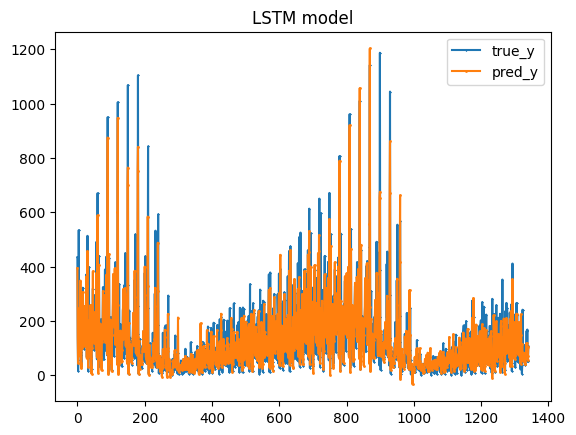

In [28]:
plt.title("LSTM model")
x=[i for i in range(len(y_valid))]
plt.plot(x,y_valid,marker="x",markersize=1,label="true_y")
plt.plot(x,preds,marker="o",markersize=1,label="pred_y")
plt.legend()
plt.show()

In [31]:
loss = 0
for i in range(len(y_valid)):
    loss += ((preds[i]-y_valid[i])**2)**0.5
    
print("总误差是{}".format(loss))

总误差是55521.17622578144
